In [8]:
import os
import tensorflow as tf

In [9]:
import pandas as pd
import numpy as np

import sklearn.model_selection
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers.recurrent import LSTM
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import time
import matplotlib.pyplot as plt
from numpy import newaxis



Using TensorFlow backend.


In [10]:
from google.colab import drive
drive.mount('/content/drive')


Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [40]:
!ls "/content/drive/My Drive/ML Projects/stock_prediction"
fundamentals = pd.read_csv("/content/drive/My Drive/ML Projects/stock_prediction/fundamentals.csv")
prices = pd.read_csv("/content/drive/My Drive/ML Projects/stock_prediction/prices.csv")
prices_split = pd.read_csv("/content/drive/My Drive/ML Projects/stock_prediction/prices-split-adjusted.csv")

fundamentals.csv  prices.csv  prices-split-adjusted.csv  securities.csv


In [161]:
apple = prices_split[prices_split['symbol']=='AAPL']
apple_stock_prices = apple.close.values.astype('float32')
apple_stock_prices = apple_stock_prices.reshape(1762, 1)
apple_stock_prices.shape
apple

,date,symbol,open,close,low,high,volume
254,2010-01-04,AAPL,30.490000,30.572857,30.340000,30.642857,123432400.0
721,2010-01-05,AAPL,30.657143,30.625713,30.464285,30.798571,150476200.0
1189,2010-01-06,AAPL,30.625713,30.138571,30.107143,30.747143,138040000.0
1657,2010-01-07,AAPL,30.250000,30.082857,29.864286,30.285715,119282800.0
2125,2010-01-08,AAPL,30.042856,30.282858,29.865715,30.285715,111902700.0
...,...,...,...,...,...,...,...
848767,2016-12-23,AAPL,115.589996,116.519997,115.589996,116.519997,14249500.0
849267,2016-12-27,AAPL,116.519997,117.260002,116.489998,117.800003,18296900.0
849767,2016-12-28,AAPL,117.519997,116.760002,116.199997,118.019997,20905900.0
850267,2016-12-29,AAPL,116.449997,116.730003,116.400002,117.110001,15039500.0


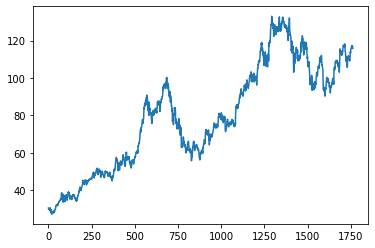

In [162]:
plt.plot(apple_stock_prices)
plt.show()
scaler = MinMaxScaler(feature_range=(0, 1))
apple_stock_prices1 = scaler.fit_transform(apple_stock_prices)

In [163]:
train_size = int(len(apple_stock_prices1) * 0.80)
test_size = len(apple_stock_prices1) - train_size
train, test = apple_stock_prices1[0:train_size,:], apple_stock_prices1[train_size:len(apple_stock_prices1),:]
print(len(train), len(test))

1409 353


In [164]:
def create_dataset(dataset, look_back=1):
	dataX, dataY = [], []
	for i in range(len(dataset)-look_back-1):
		a = dataset[i:(i+look_back), 0]
		dataX.append(a)
		dataY.append(dataset[i + look_back, 0])
	return np.array(dataX), np.array(dataY)

In [165]:
# reshape into X=t and Y=t+1
look_back = 60
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
trainX.shape

(1348, 60)

In [166]:
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))

trainX.shape

testX.shape

(292, 60, 1)

In [167]:
os.environ["CUDA_VISIBLE_DEVICES"] = "0"
gpus = tf.config.list_physical_devices("GPU")
print(gpus)
if len(gpus) == 1 : 
    strategy = tf.distribute.OneDeviceStrategy(device = "/gpu:0")
else:
    strategy = tf.distribute.MirroredStrategy()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [168]:
tf.config.optimizer.set_experimental_options({"auto_mixed_precision" : True})
print("Mixed precision enabled")

Mixed precision enabled


In [169]:
reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor= "loss", factor = 0.5, patience = 10,
                                                 min_lr = 0.000001, verbose = 1)
monitor_es = tf.keras.callbacks.EarlyStopping(monitor= "loss", patience = 25, restore_best_weights= False, verbose = True)

In [170]:
model = tf.keras.Sequential()
model.add(tf.keras.layers.LSTM(units = 12, return_sequences = True, input_shape = (trainX.shape[1], 1)))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.LSTM(units = 12, return_sequences = True))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.LSTM(units = 12, return_sequences = False))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(units = 10, activation = "relu"))
model.add(tf.keras.layers.Dense(units = 1, activation = "relu"))

In [171]:
model.compile(tf.keras.optimizers.Adam(lr = 0.001), loss = "mean_squared_error")

model.summary()

Model: "sequential_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_27 (LSTM)               (None, 60, 12)            672       
_________________________________________________________________
dropout_27 (Dropout)         (None, 60, 12)            0         
_________________________________________________________________
lstm_28 (LSTM)               (None, 60, 12)            1200      
_________________________________________________________________
dropout_28 (Dropout)         (None, 60, 12)            0         
_________________________________________________________________
lstm_29 (LSTM)               (None, 12)                1200      
_________________________________________________________________
dropout_29 (Dropout)         (None, 12)                0         
_________________________________________________________________
dense_26 (Dense)             (None, 10)              

In [172]:
with tf.device("/device:GPU:0"):
    history = model.fit(trainX, trainY, epochs = 10, batch_size = 16, callbacks = [reduce_lr, monitor_es])

Epoch 1/10
85/85 [==============================] - 1s 10ms/step - loss: 0.0875 - lr: 0.0010
Epoch 2/10
85/85 [==============================] - 1s 10ms/step - loss: 0.0182 - lr: 0.0010
Epoch 3/10
85/85 [==============================] - 1s 11ms/step - loss: 0.0131 - lr: 0.0010
Epoch 4/10
85/85 [==============================] - 1s 10ms/step - loss: 0.0123 - lr: 0.0010
Epoch 5/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0088 - lr: 0.0010
Epoch 6/10
85/85 [==============================] - 1s 10ms/step - loss: 0.0080 - lr: 0.0010
Epoch 7/10
85/85 [==============================] - 1s 9ms/step - loss: 0.0074 - lr: 0.0010
Epoch 8/10
85/85 [==============================] - 1s 11ms/step - loss: 0.0062 - lr: 0.0010
Epoch 9/10
85/85 [==============================] - 1s 10ms/step - loss: 0.0060 - lr: 0.0010
Epoch 10/10
85/85 [==============================] - 1s 11ms/step - loss: 0.0052 - lr: 0.0010


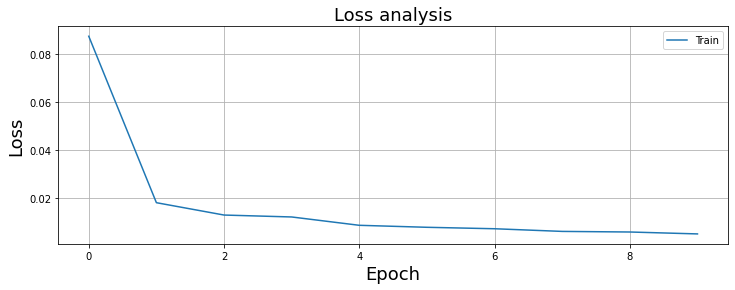

In [173]:
plt.figure(figsize = (12, 4))
plt.plot(history.history["loss"], label = "Training loss")
plt.title("Loss analysis", fontsize = 18)
plt.xlabel("Epoch", fontsize = 18)
plt.ylabel("Loss", fontsize = 18)
plt.legend(["Train"])
plt.grid("both")

In [176]:
predicted = model.predict(testX)
predicted = scaler.inverse_transform(predicted)
print(predicted)

#trainX.shape
#testX.shape

apple_stock_prices1 = scaler.inverse_transform(apple_stock_prices1)


[[105.85477 ]
 [106.21328 ]
 [106.60633 ]
 [107.01995 ]
 [107.44067 ]
 [107.85572 ]
 [108.24064 ]
 [108.57453 ]
 [108.84557 ]
 [109.03718 ]
 [109.14771 ]
 [109.18301 ]
 [109.164734]
 [109.11989 ]
 [109.06955 ]
 [109.02163 ]
 [108.98327 ]
 [108.956276]
 [108.9395  ]
 [108.932655]
 [108.93198 ]
 [108.92988 ]
 [108.9166  ]
 [108.900856]
 [108.88956 ]
 [108.88491 ]
 [108.87822 ]
 [108.86362 ]
 [108.82819 ]
 [108.76024 ]
 [108.64798 ]
 [108.48954 ]
 [108.280815]
 [108.010445]
 [107.680176]
 [107.29906 ]
 [106.88394 ]
 [106.449585]
 [106.0031  ]
 [105.55916 ]
 [105.12542 ]
 [104.698296]
 [104.27617 ]
 [103.849724]
 [103.405464]
 [102.91952 ]
 [102.38216 ]
 [101.80233 ]
 [101.20003 ]
 [100.58256 ]
 [ 99.966415]
 [ 99.35686 ]
 [ 98.75583 ]
 [ 98.16809 ]
 [ 97.597046]
 [ 97.069534]
 [ 96.59706 ]
 [ 96.186066]
 [ 95.80833 ]
 [ 95.44486 ]
 [ 95.10174 ]
 [ 94.78103 ]
 [ 94.474335]
 [ 94.185165]
 [ 93.91878 ]
 [ 93.666084]
 [ 93.425095]
 [ 93.1962  ]
 [ 92.976555]
 [ 92.76186 ]
 [ 92.55195 ]
 [ 92.

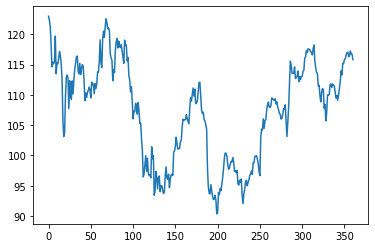

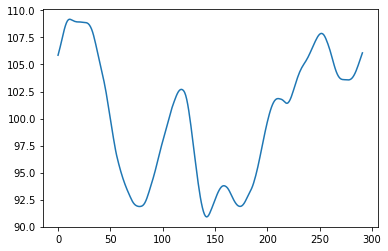

In [178]:
f = plt.figure(1)
plt.plot(apple_stock_prices1[1401:])
f.show()

g = plt.figure(2)
plt.plot(predicted)
g.show()
